In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this tutorial, we will do implement following steps for a classification task : 

We will implement the following steps - 

1.   Download the MNIST dataset 
2.   Load and Pre-process the dataset
3.   Define the model
4.   Define the loss function and optimizer
5.   Train the network on the training data
6.   Define the evaluation metric
7.   Report results on the train and test data (using the evaluation metric)


# 1. Download the MNIST Dataset 


In [2]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*.gz

--2021-09-25 03:52:02--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2021-09-25 03:52:03 (89.2 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2021-09-25 03:52:03--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===========

In [3]:
!pip install pypng

     |████████████████████████████████| 48 kB 2.4 MB/s 


In [4]:
from tqdm import *

In [5]:
# source: https://github.com/myleott/mnist_png/blob/master/convert_mnist_to_png.py
import os
import struct
import sys

from array import array
from os import path

import png

# source: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    return lbl, img, size, rows, cols

def write_dataset(labels, data, size, rows, cols, output_dir):
    # create output directories
    output_dirs = [
        path.join(output_dir, str(i))
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)

    # write data
    for (i, label) in tqdm(enumerate(labels)):
        output_filename = path.join(output_dirs[label], str(i) + ".png")
        with open(output_filename, "wb") as h:
            w = png.Writer(cols, rows, greyscale=True)
            data_i = [
                data[ (i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols) ]
                for j in range(rows)
            ]
            w.write(h, data_i)

input_path = '/content'
output_path = '/content/mnist'
for dataset in ["training", "testing"]:
    labels, data, size, rows, cols = read(dataset, input_path)
    write_dataset(labels, data, size, rows, cols,
                  path.join(output_path, dataset))

60000it [00:14, 4173.27it/s]
10000it [00:02, 3753.69it/s]


# 2. Load and Pre-Process the data 

In [6]:
#Create csv files
import glob 
import pandas as pd

for split in ['training', 'testing']:
    rows = []
    for folder in glob.glob('/content/mnist/'+ split + '/*'):
        label = folder.split("/")[-1]
        for image_path in glob.glob(folder+ "/*"):
            rows.append([image_path,label])
    df=pd.DataFrame(rows,columns=['Path','Label'])
    df.to_csv(split + ".csv", index = False)

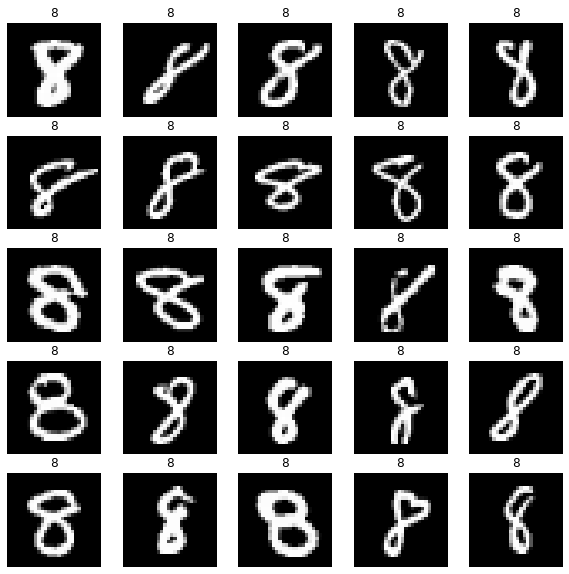

In [7]:
# Visualize the dataset 

import matplotlib.pyplot as plt
import numpy as np
import cv2

def view_dataset(paths, labels, method='cv2'):
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    for ax, path, label in zip(flatted_axs, paths[:25], labels[:25]):
        if method == 'cv2':
            img = cv2.imread(path, 3)
        elif method == 'tf':
            img = try_tf_image(path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show() 


df = pd.read_csv('/content/training.csv')
paths = df['Path'][:25]
labels = df['Label'][:25]

view_dataset(paths, labels)

In [10]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

class Dataset(Dataset):
    def __init__(self, data_split, toy=False):
     
        df = pd.read_csv(data_split)
        
        # Remove any paths for which the image files do not exist
        #df = df[df["Path"].apply(os.path.exists)]
      
        #print ("%s size %d" % (data_split, df.shape[0]))

        #Could remove
        #if toy:
            #df = df.sample(frac=0.01)

        self.img_paths = df["Path"].tolist()

        self.labels = df["Label"].tolist()

        self.n_classes = len(self.labels)

    def __getitem__(self, index):
           img = np.array(Image.open(self.img_paths[index])).astype(np.float32) / 255.
           label = self.labels[index]
           label_vec = torch.LongTensor([label])
           return img, label_vec
          

    def __len__(self):
        return len(self.img_paths)

In [11]:
train_dataset = Dataset('training.csv')
test_dataset = Dataset('testing.csv')


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                         shuffle=False)

print(len(train_loader))
print(len(test_loader))

600
100


# 3. Define the Model 

In [12]:
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
model = nn.Sequential(
          Flatten(),
          nn.Linear(784, 50),
          nn.ReLU(),
          nn.Linear(50, 10),
          nn.Softmax())


# 4. Define loss function and optimizer

In [14]:
import torch.optim as optim

# Define the cost function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, learning rate 
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 5. Train the Model

In [15]:
for epoch in range(2): 
      for i, (inputs, labels) in enumerate(train_loader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model(inputs)
        
        # calculate the loss
        loss = criterion(outputs, labels.squeeze(1))
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:0, Iteration: 0, training cost = 2.302121639251709
Epoch:0, Iteration: 100, training cost = 1.551684856414795
Epoch:0, Iteration: 200, training cost = 1.566657304763794
Epoch:0, Iteration: 300, training cost = 1.5858577489852905
Epoch:0, Iteration: 400, training cost = 1.545067548751831
Epoch:0, Iteration: 500, training cost = 1.5099284648895264
Epoch:1, Iteration: 0, training cost = 1.5268011093139648
Epoch:1, Iteration: 100, training cost = 1.487734317779541
Epoch:1, Iteration: 200, training cost = 1.565764307975769
Epoch:1, Iteration: 300, training cost = 1.5289541482925415
Epoch:1, Iteration: 400, training cost = 1.5416637659072876
Epoch:1, Iteration: 500, training cost = 1.4905667304992676


# 6. Define evaluation metric

In [17]:
def calculate_accuracy(loader):
    total = 0
    correct = 0
  
    all_images = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()
            
            all_images.append(images)
            all_preds.append(predicted.numpy())
            all_labels.append(labels)

    return 100 * correct / total, all_images, all_preds, all_labels

# 7. Report results on the train and test data

In [18]:
train_accuracy, _ , _, _ = calculate_accuracy(train_loader)
test_accuracy, images, preds, labels = calculate_accuracy(test_loader)

print('Train accuracy: %f' % train_accuracy)
print('Test accuracy: %f' % test_accuracy)

images = np.concatenate(images, axis=0)
preds = np.concatenate(preds, axis=0)
labels = np.squeeze(np.concatenate(labels, axis=0))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train accuracy: 95.048333
Test accuracy: 94.990000


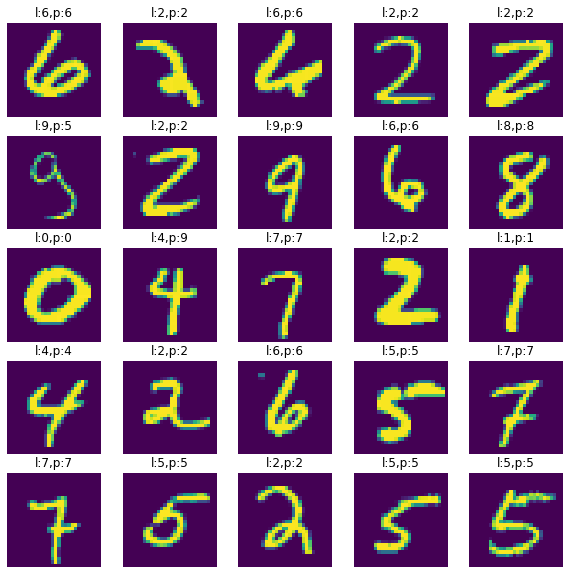

In [19]:
import matplotlib.pyplot as plt
import numpy as np


def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

images, labels, preds = unison_shuffled_copies(images, labels, preds)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
flatted_axs = [item for one_ax in axs for item in one_ax]
for ax, img, label, pred in zip(flatted_axs, images[:25], labels[:25], preds[:25]):
    ax.imshow(np.reshape(img, (28,28)))
    ax.set_title('l:{},p:{}'.format(label, pred))
    ax.axis('off')
plt.show()  

In [25]:
torch.save(model.state_dict(), 'drive/MyDrive/ML-Introduction/mnist_checkpoint.pth')

In [ ]:
% cd drive/MyDrive/ML-Introduction/

In [ ]:

import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np

In [ ]:
!cd drive/My\ Drive/ML-Introduction

In [ ]:
batch_size = 128
num_epochs = 2
device = torch.device('cuda')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323179
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.226682
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.491852
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.898383
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.630561

Test set: Average loss: 0.0046, Accuracy: 8918/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.741472
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.612713
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.628452
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.433390
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.598243

Test set: Average loss: 0.0027, Accuracy: 9403/10000 (94%)



In [ ]:
!rm -r mnist_data/

rm: cannot remove 'mnist_data/': No such file or directory
